# AMPSphere v.2022-03¶

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__


### Analysis of c_AMP density in different genera

Most of our data shows that species more abundandant in these environments, tend to have more AMP genes. To address this issue, we normalized the number of c_AMP genes in these genera dividing it by the assembled base pairs per genera.

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import Phylo
from re import sub
from tqdm import tqdm
from itertools import combinations
from matplotlib.colors import to_hex
from scipy.stats import spearmanr, mannwhitneyu
from scipy.stats import percentileofscore as posr
from statsmodels.stats.multitest import multipletests

In [2]:
# load data
# getting amp genes per taxon
taxonomy_amps = pd.read_table('../data_folder/complete_amps_associated_taxonomy.tsv.gz')
taxonomy_amps = taxonomy_amps[taxonomy_amps.level.isin(['species', 'genus'])]
#taxonomy_amps['source'] = taxonomy_amps['source'].str.replace('Prevotellamassilia', 'Prevotella massilia')
taxonomy_amps['fixed'] = taxonomy_amps.source.apply(lambda x: x.split()[0])
taxonomy_amps = taxonomy_amps.groupby('fixed').agg('size')
taxonomy_amps = taxonomy_amps.sort_values()

bps = pd.read_table('../data_folder/bps-per-taxon.tsv.xz', header='infer')
bps = bps[bps.level.isin(['species', 'genus'])]
#bps['name'] = bps['name'].str.replace('Prevotellamassilia', 'Prevotella massilia')
bps['fixed'] = bps['name'].apply(lambda x: x.split(' ')[0])

In [3]:
# work dfs
taxbps = bps[['fixed', 'nbps']].groupby('fixed').agg('sum')
taxbps = pd.concat([taxonomy_amps, taxbps], axis=1).fillna(0)
taxbps = taxbps.rename({0: 'amp_genes'}, axis=1)
taxbps['amps_per_Gbp'] = taxbps['amp_genes'] * 1e9 / taxbps['nbps']

Text(0, 0.5, 'AMP genes per genus')

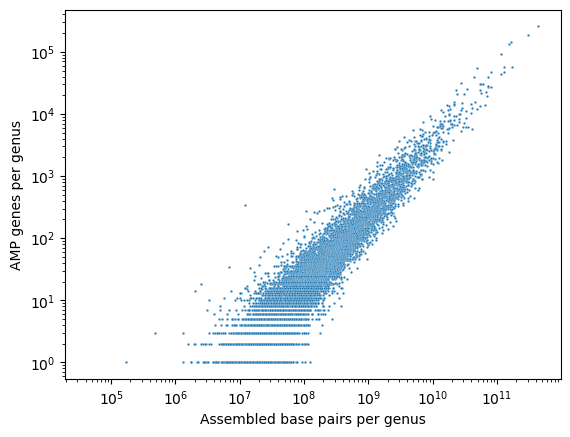

In [4]:
# plot AMP per bp per taxon
sns.scatterplot(data=taxbps, x='nbps', y='amp_genes', s=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Assembled base pairs per genus')
plt.ylabel('AMP genes per genus')

In [5]:
# get statistics
a = taxbps.loc[taxbps.amp_genes > 0, 'nbps'].mean() / 1e9
b = taxbps.loc[taxbps.amp_genes > 0, 'nbps'].std() / 1e9
c = taxbps.loc[taxbps.amp_genes == 0, 'nbps'].mean() / 1e9
d = taxbps.loc[taxbps.amp_genes == 0, 'nbps'].std() / 1e9

print(f'''Statistics for the assembly bps by taxon:

- Taxa presenting AMPs
Average: {a:.2f} Gbp
Stdev.: {b:.2f} Gbp

- Taxa not presenting AMPs
Average: {c:.2f} Gbp
Stdev.: {d:.2f} Gbp''')

Statistics for the assembly bps by taxon:

- Taxa presenting AMPs
Average: 1.12 Gbp
Stdev.: 8.10 Gbp

- Taxa not presenting AMPs
Average: 0.01 Gbp
Stdev.: 0.01 Gbp


In [6]:
# calculating quantiles for top taxa in AMPSphere
idf = taxbps[taxbps.amps_per_Gbp > 0]
idf = idf.sort_values(by='amps_per_Gbp')
idf = idf['amps_per_Gbp']

print('Percentile of AMP densities by genera:\n')
print('Bradyrhizobium', '\t', posr(idf, idf.loc['Bradyrhizobium'], kind='rank'))
print('Prevotella', '\t', posr(idf, idf.loc['Prevotella'], kind='rank'))
print('Pelagibacter', '\t', posr(idf, idf.loc['Pelagibacter'], kind='rank'))
print('Faecalibacterium', '\t', posr(idf, idf.loc['Faecalibacterium'], kind='rank'))
print('CAG-110', '\t', posr(idf, idf.loc['CAG-110'], kind='rank'))

Percentile of AMP densities by genera:

Bradyrhizobium 	 84.08706166868198
Prevotella 	 95.53808948004837
Pelagibacter 	 85.16324062877872
Faecalibacterium 	 98.25876662636034
CAG-110 	 94.03869407496977


In [7]:
# add error to normalized AMPs per Gbp
p = taxbps['amp_genes'] / taxbps['nbps']
taxbps['MOE'] = np.sqrt(p * (1 - p) / taxbps['nbps'])

# our confidence level is set to 95%
# then Z=1.96
taxbps['MOE'] = 1.96 * taxbps['MOE']  
# fix proportion to Gbp
taxbps['MOE'] = taxbps['MOE'] * 1e9

taxbps['UL'] = taxbps['amps_per_Gbp'] + taxbps['MOE']
taxbps['LL'] = taxbps['amps_per_Gbp'] - taxbps['MOE']
taxbps['VAR_pct'] = taxbps['MOE'] * 100 / taxbps['amps_per_Gbp']

fdata = taxbps[taxbps.VAR_pct <= 10]

Text(0.5, 0, 'AMP density (c_AMPs per Gbp)')

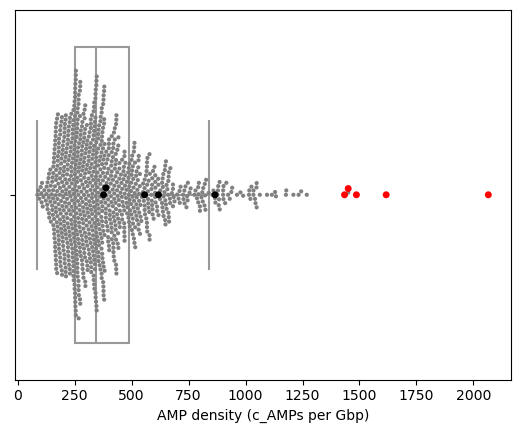

In [8]:
sns.boxplot(x=fdata['amps_per_Gbp'],
            showfliers=False,
            color='white')

sns.swarmplot(x=fdata['amps_per_Gbp'],
              color='gray',
              s=3)

toptaxa_ampsphere = ['Prevotella', 'Bradyrhizobium', 'Pelagibacter', 'Faecalibacterium', 'CAG-110']
toptaxa_density = ['Algorimicrobium', 'TMED78', 'SFJ001', 'STGJ01', 'CAG-462']

sns.swarmplot(x=fdata.loc[toptaxa_ampsphere,
                         'amps_per_Gbp'],
              color='black',
              s=5)

sns.swarmplot(x=fdata.loc[toptaxa_density,
                         'amps_per_Gbp'],
              color='red',
              s=5)

plt.xlabel('AMP density (c_AMPs per Gbp)')

### Checking taxonomy groups using AMP density

In [9]:
taxbps = taxbps.drop(['UL', 'LL'], axis=1).reset_index()
taxbps.rename({'fixed': 'genus'}, axis=1, inplace=True)

In [12]:
# prepare data
tax = pd.read_table("../data_folder/bac120_taxonomy_r207.tsv.xz",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])

tax_one = tax.copy()
tax_one.drop('species', axis=1, inplace=True)
tax_one = tax_one.drop_duplicates()
tax_one['genus'] = [x[3:] for x in tax_one.genus]

tax_one = tax_one.reset_index(drop=True)
tax_one = tax_one.drop_duplicates()

### Supplementary Table S7

In [13]:
taxbps = taxbps.merge(on='genus', right=tax_one)

# only phyla with 100 genera or more
k = taxbps.groupby('phylum').agg('size').sort_values()
k = k[k >= 100].index

fdata = taxbps[taxbps.phylum.isin(k)]
fdata = fdata.sort_values(by='phylum')

fdata = fdata[['phylum', 'genus',
               'amp_genes', 'nbps',
               'amps_per_Gbp', 'MOE',
               'VAR_pct']]

fdata.to_csv('Table S7.tsv',
             sep='\t',
             header=True,
             index=None)

In [14]:
# select just genera with a maximum error of 10%
fdata = fdata[fdata.VAR_pct <= 10]
fdata

phylum            genus  amp_genes         nbps  \
6982    p__Acidobacteriota     Edaphobacter     2288.0  10539953147   
6823    p__Acidobacteriota          UBA7540     1206.0   3792966097   
6816    p__Acidobacteriota  2-12-FULL-66-21     1171.0   5214663174   
6557    p__Acidobacteriota           PSRF01      594.0   5857902959   
6560    p__Acidobacteriota           QHXN01      597.0   2852863681   
...                    ...              ...        ...          ...   
6553  p__Verrucomicrobiota    Lacunisphaera      592.0   1951235316   
6840  p__Verrucomicrobiota             SW10     1283.0   3118421073   
6457  p__Verrucomicrobiota    Roseibacillus      471.0   2299564112   
6882  p__Verrucomicrobiota      Victivallis     1480.0   3521981537   
6474  p__Verrucomicrobiota          UBA3636      489.0   1045214630   

      amps_per_Gbp        MOE   VAR_pct  
6982    217.078764   8.894988  4.097585  
6823    317.956968  17.945299  5.643939  
6816    224.559087  12.861991  5.727665  
6557    101.401475   8.154683  8.041977  
6560    209.263416  16.786578  8.021745  
...            ...        ...       ...  
6553    303.397543  24.440338  8.055549  
6840    411.426158  22.513061  5.471957  
6457    204.821426  18.497837  9.031202  
6882    420.217989  21.409167  5.094776  
6474    467.846494  41.467220  8.863424  

[732 rows x 7 columns]

In [15]:
# eliminate outliers using Tukey fences
q1, q3 = fdata.amps_per_Gbp.quantile([0.25, 0.75])
iqr = q3 - q1
ul, ll = q3 + (1.5*iqr), q1 - (1.5*iqr)
fdata = fdata[(fdata.amps_per_Gbp >= ll) & (fdata.amps_per_Gbp <= ul)]

In [16]:
# determine order of phyla by their Q50
porder = fdata.groupby('phylum')['amps_per_Gbp'].quantile(0.5)
porder = porder.sort_values()
print(porder)

porder = porder.index

colors = {'p__Acidobacteriota': (174/255, 199/255, 232/255, 100/255),
          'p__Actinobacteriota': (44/255, 160/255, 44/255, 100/255),
          'p__Bacteroidota': (214/255, 39/255, 40/255, 100/255),
          'p__Firmicutes': (255/255, 187/255, 120/255, 100/255),
          'p__Firmicutes_A': (31/255, 119/255, 180/255, 100/255),
          'p__Proteobacteria': (152/255, 223/255, 138/255, 100/255),
          'p__Verrucomicrobiota': (255/255, 127/255, 14/255, 100/255),
          'other': (128/255, 128/255, 128/255, 100/255)}

fdata['class'] = [k if k in colors else 'other' for k in fdata.phylum]
fdata['class'] = fdata['class'].apply(lambda x: x.replace('p__', ''))
fdata['class'] = fdata['class'].apply(lambda x: x.replace('_', ' '))


phylum
p__Planctomycetota      204.962991
p__Acidobacteriota      228.667584
p__Chloroflexota        263.098695
p__Cyanobacteria        268.690168
p__Desulfobacterota     269.979473
p__Patescibacteria      281.967419
p__Verrucomicrobiota    289.116904
p__Bacteroidota         306.189408
p__Actinobacteriota     328.324792
p__Proteobacteria       339.359324
p__Firmicutes           379.297985
p__Firmicutes_A         413.157309
Name: amps_per_Gbp, dtype: float64


/tmp/ipykernel_1326147/1013936292.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['class'] = [k if k in colors else 'other' for k in fdata.phylum]
/tmp/ipykernel_1326147/1013936292.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['class'] = fdata['class'].apply(lambda x: x.replace('p__', ''))
/tmp/ipykernel_1326147/1013936292.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Figure 4C

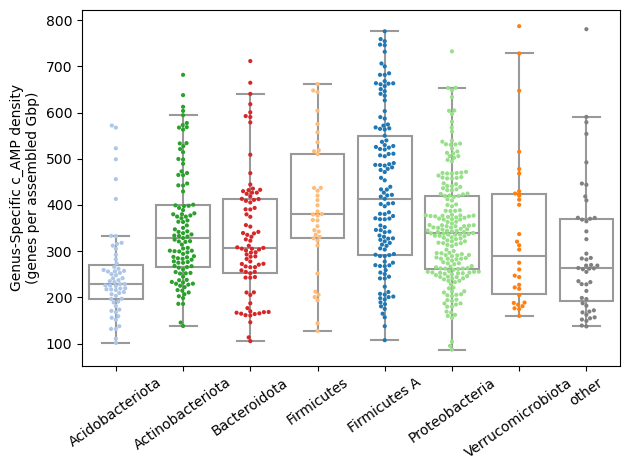

In [17]:
sns.boxplot(data=fdata,
            x='class',
            y='amps_per_Gbp',
            order=['Acidobacteriota',
                   'Actinobacteriota',
                   'Bacteroidota',
                   'Firmicutes',
                   'Firmicutes A',
                   'Proteobacteria',
                   'Verrucomicrobiota',
                   'other'],
            showfliers=False,
            color='white')

palette = {k.replace('p__', '').replace('_', ' '): v for k, v in colors.items()}

sns.swarmplot(data=fdata,
              x='class',
              y='amps_per_Gbp',
              hue='class',
              order=['Acidobacteriota',
                   'Actinobacteriota',
                   'Bacteroidota',
                   'Firmicutes',
                   'Firmicutes A',
                   'Proteobacteria',
                   'Verrucomicrobiota',
                   'other'],
              palette=palette,
              s=3)
              
plt.legend().remove()
plt.xlabel('')
plt.xticks(rotation=35)
plt.ylabel('Genus-Specific c_AMP density\n(genes per assembled Gbp)')
plt.tight_layout()
plt.savefig('phyladist_density.svg')
plt.show()

In [18]:
test = []
for i, j in combinations(porder, 2):
    u, p = mannwhitneyu(fdata[fdata.phylum == i]['amps_per_Gbp'],
                        fdata[fdata.phylum == j]['amps_per_Gbp'])
    test.append((i, j, u, p))

test = pd.DataFrame(test,
                    columns=['tax1', 'tax2',
                             'u_stat', 'p-value'])

_, test['p-value'], _, _ = multipletests(test['p-value'],
                                         method='bonferroni',
                                         is_sorted=False,
                                         returnsorted=False)

test = test[test['p-value'] < 5e-2]
test

tax1                 tax2  u_stat       p-value
10   p__Planctomycetota      p__Firmicutes_A   278.0  2.182980e-02
16   p__Acidobacteriota      p__Bacteroidota  1428.0  2.295301e-03
17   p__Acidobacteriota  p__Actinobacteriota  1404.0  4.356972e-07
18   p__Acidobacteriota    p__Proteobacteria  2744.0  2.363499e-08
19   p__Acidobacteriota        p__Firmicutes   441.0  6.548473e-05
20   p__Acidobacteriota      p__Firmicutes_A  1355.0  3.067119e-10
59      p__Bacteroidota      p__Firmicutes_A  3415.0  3.298929e-03
62  p__Actinobacteriota      p__Firmicutes_A  4836.0  3.928120e-02
64    p__Proteobacteria      p__Firmicutes_A  9151.0  2.475119e-03

### Analysis of c_AMP density regarding taxonomy distribution in the tree of life

In [20]:
# load lineages from GTDB
gtdb_tree = Phylo.read('../data_folder/bac120_r202.tre', 'newick')
taxaintree = [i.name for i in gtdb_tree.get_terminals()]

tax = pd.read_table("../data_folder/bac120_taxonomy_r207.tsv.xz",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])

# get common genomes from tree and lineage
taxaintree = set(tax.index).intersection(set(taxaintree))
tax = tax.loc[taxaintree, 'genus']
tax = tax.reset_index()
tax.rename({'index': 'genome'}, axis=1, inplace=True)

/tmp/ipykernel_1326147/530113021.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tax = tax.loc[taxaintree, 'genus']


In [21]:
# only phyla with 100 genera or more
k = taxbps.groupby('phylum').agg('size').sort_values()
k = k[k >= 100].index

fdata = taxbps[taxbps.phylum.isin(k)]
fdata = fdata.sort_values(by='phylum')

# only taxa with maximum 10% of error
fdata = fdata[fdata.VAR_pct <= 10]

# merge data
tax.genus = [x[3:] for x in tax.genus]
tax = tax.merge(on='genus', right=fdata)
tax

genome             genus  amp_genes         nbps  \
0     RS_GCF_900111555.1      Marinobacter     1567.0   5337879189   
1     RS_GCF_002744715.1      Marinobacter     1567.0   5337879189   
2     GB_GCA_002707215.1      Marinobacter     1567.0   5337879189   
3     RS_GCF_001045555.1      Marinobacter     1567.0   5337879189   
4     RS_GCF_001717765.1      Marinobacter     1567.0   5337879189   
...                  ...               ...        ...          ...   
7762  GB_GCA_001603025.1           Firm-10     1507.0   1523242815   
7763  GB_GCA_001920085.1   3-1-20CM-4-69-9     3026.0   7967893207   
7764  RS_GCF_001405555.1  Fusicatenibacter    20596.0  31149965484   
7765  GB_GCA_002169685.1           TMED211      487.0    553296546   
7766  GB_GCA_002779455.1   0-14-0-80-60-11      733.0   1241095717   

      amps_per_Gbp        MOE   VAR_pct       domain               phylum  \
0       293.562283  14.535225  4.951326  d__Bacteria    p__Proteobacteria   
1       293.562283  14.535225  4.951326  d__Bacteria    p__Proteobacteria   
2       293.562283  14.535225  4.951326  d__Bacteria    p__Proteobacteria   
3       293.562283  14.535225  4.951326  d__Bacteria    p__Proteobacteria   
4       293.562283  14.535225  4.951326  d__Bacteria    p__Proteobacteria   
...            ...        ...       ...          ...                  ...   
7762    989.336687  49.950903  5.048929  d__Bacteria      p__Firmicutes_A   
7763    379.774166  13.531531  3.563047  d__Bacteria  p__Actinobacteriota   
7764    661.188534   9.030043  1.365729  d__Bacteria      p__Firmicutes_A   
7765    880.178999  78.174012  8.881604  d__Bacteria    p__Proteobacteria   
7766    590.607147  42.756550  7.239423  d__Bacteria  p__Desulfobacterota   

                       class                  order              family  
0     c__Gammaproteobacteria     o__Pseudomonadales    f__Oleiphilaceae  
1     c__Gammaproteobacteria     o__Pseudomonadales    f__Oleiphilaceae  
2     c__Gammaproteobacteria     o__Pseudomonadales    f__Oleiphilaceae  
3     c__Gammaproteobacteria     o__Pseudomonadales    f__Oleiphilaceae  
4     c__Gammaproteobacteria     o__Pseudomonadales    f__Oleiphilaceae  
...                      ...                    ...                 ...  
7762           c__Clostridia  o__Christensenellales           f__CAG-74  
7763      c__Thermoleophilia          o__Gaiellales      f__Gaiellaceae  
7764           c__Clostridia      o__Lachnospirales  f__Lachnospiraceae  
7765  c__Alphaproteobacteria             o__TMED127          f__TMED127  
7766        c__Desulfobaccia     o__Desulfobaccales  f__0-14-0-80-60-11  

[7767 rows x 12 columns]

In [22]:
colors = {'p__Acidobacteriota': (174/255, 199/255, 232/255, 100/255),
          'p__Actinobacteriota': (44/255, 160/255, 44/255, 100/255),
          'p__Bacteroidota': (214/255, 39/255, 40/255, 100/255),
          'ddp__Firmicutes': (255/255, 187/255, 120/255, 100/255),
          'p__Firmicutes_A': (31/255, 119/255, 180/255, 100/255),
          'p__Proteobacteria': (152/255, 223/255, 138/255, 100/255),
          'p__Verrucomicrobiota': (255/255, 127/255, 14/255, 100/255),
          'other': (128/255, 128/255, 128/255, 100/255)}

In [23]:
# keep only 1 genome per taxon
ndata = tax.groupby('genus').apply(lambda x: x.head(1))
ndata = ndata.reset_index(drop=True)

# create a hash table for genomes and genera 
taxkeys = ndata[['genome', 'genus']]
taxkeys = taxkeys.set_index('genome')
taxkeys = taxkeys.to_dict()['genus']

# eliminate genomes without AMP density
# or redundant
for i in tqdm(gtdb_tree.get_terminals()):
    if i.name in taxkeys: i.name = taxkeys[i.name]
    else: gtdb_tree.prune(i)

# excluding discrepant value (5 times the second most abundant)
# gtdb_tree.prune('Shimwellia')

# export tree file for iTOL
# Phylo.write(gtdb_tree, 'out.tre', 'newick')

100%|████████████████████████████████████| 23458/23458 [00:33<00:00, 705.99it/s]


In [24]:
# reduce tree
# tree is too big with many small phylum
# reducing tree
k = ndata.groupby('phylum').agg('size')
k = k[k >= 15].index
ndata = ndata[ndata.phylum.isin(k)]
ksp=set(ndata.genus)

# edit tree 
for i in tqdm(gtdb_tree.get_terminals()):
    if i.name not in ksp: gtdb_tree.prune(i.name)

#Phylo.write(gtdb_tree, 'red_out.tre', 'newick')

100%|██████████████████████████████████████| 665/665 [00:00<00:00, 12735.26it/s]


In [25]:
# export annotation of phylum
cmap = plt.cm.get_cmap('tab20')

phylum = dict()
for idx, i in enumerate(set(ndata.phylum)):
    phylum[i] = to_hex(cmap(idx))

# {'Acidobacteriota': '#1f77b4', 'Actinobacteriota': '#aec7e8', 'Bacteroidota': '#ff7f0e', 'Firmicutes': '#ffbb78', 'Firmicutes_A': '#2ca02c', 'Proteobacteria': '#98df8a', 'Verrucomicrobiota': '#d62728'}

ndata['color'] = ndata.phylum.apply(lambda x: phylum[x])

ndata[['phylum', 'color']].sort_values(by='phylum').drop_duplicates()

# annotation for color strip in iTOL
# ndata[['genus', 'color', 'phylum']].to_csv('out.anno_ph.txt', sep='\t', header=None, index=None)

phylum    color
1      p__Acidobacteriota  #aec7e8
297   p__Actinobacteriota  #d62728
47        p__Bacteroidota  #1f77b4
604         p__Firmicutes  #ffbb78
584       p__Firmicutes_A  #2ca02c
527     p__Proteobacteria  #ff7f0e
511  p__Verrucomicrobiota  #98df8a

In [26]:
# annotation of AMP density
q2 = ndata['amps_per_Gbp'].quantile(0.5)
print(f'Standard line representing Q50: y={q2}')

ndata[['genus', 'amps_per_Gbp']]

Standard line representing Q50: y=339.052465484754


genus  amps_per_Gbp
1     12-FULL-67-14b    219.688616
2    13-2-20CM-66-19    295.371622
3    13-2-20CM-68-14    520.983944
4               14-2    433.645906
5    2-02-FULL-65-29    228.589419
..               ...           ...
658     Vitreoscilla    502.004666
660  Winogradskyella    341.638472
661      Xanthomonas    580.276713
662        Z2-YC6860    321.335891
664         Zoogloea    653.584039

[624 rows x 2 columns]

The resulting reduced tree was produced using [iTOL](https://itol.embl.de/)
and the annotation files for AMP density and phylum.

Resulting tree is in: docs/xM-1rj4CIUbe-fe33NNI-w.svg



To reproduce the three above, you will need the files below:

In [27]:
Phylo.write(gtdb_tree, 'red_out.tre', 'newick')
ndata[['genus', 'color', 'phylum']].to_csv('out.anno_ph.txt', sep='\t', header=None, index=None)
ndata[['genus', 'amps_per_Gbp', 'MOE']].to_csv('out.anno.txt', sep='\t', header=None, index=None)